<a href="https://colab.research.google.com/github/ashma01/GANs/blob/master/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import zipfile
import shutil
import os
import pandas as pd
import random
from torchvision.utils import save_image
from IPython.display import Image
from torchvision.utils import save_image

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [2]:
!mkdir wgan_data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

mkdir: cannot create directory ‘wgan_data_faces’: File exists


In [3]:
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("wgan_data_faces/")

In [4]:
root = 'wgan_data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [5]:
# Root directory for dataset
dataroot = "wgan_data_faces"

# Batch size during training
batch_size = 64
image_size = 64
nc = 3
nz = 128
ngf = 64
ndf = 64
num_epochs = 50
beta1 = 0.0
learning_rate = 5e-5

#critin iteration
critic_iter = 5

#GP penalty 
# gp_penalty = 10

#Weight clip
clamp_num = 0.01


In [6]:
#Load celeba dataset data set

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


In [7]:
from torch.utils.data import DataLoader


dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=4)



In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda')

In [10]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach().cpu()[:nmax]), nrow=8).permute(1, 2, 0))
  
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

In [12]:
# show_batch(dataloader)

In [13]:
# custom weights initialization called on Generator and Discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [14]:
#Discriminator
class Discriminator(nn.Module):
  def __init__(self):
          super(Discriminator, self).__init__()
          self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            # nn.Sigmoid()
        )

  def forward(self, input):
      return self.main(input)     



critic = Discriminator().to(device);
critic.apply(weights_init)



Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
)

In [15]:
#Generator network 

class Generator(nn.Module):
  def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
  def forward(self, input):
          return self.main(input)

    

Generator_model = Generator().to(device);  
Generator_model.apply(weights_init) 

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [16]:
print(Generator_model)
print(critic)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


torch.Size([64, 3, 64, 64])


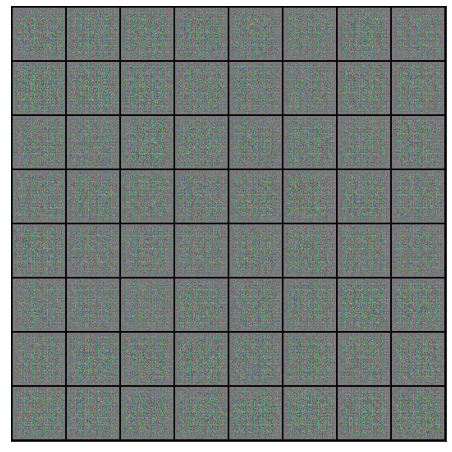

In [17]:
randon_noise = torch.randn(batch_size, nz, 1, 1).to(device) # random latent tensors
fake_images = Generator_model(randon_noise)
print(fake_images.shape)
show_images(fake_images)

In [18]:
#For discriminator training using binary cross entropy loss
# criterion = nn.BCELoss()
d_optimizer = torch.optim.RMSprop(critic.parameters(), lr=learning_rate)
g_optimizer = torch.optim.RMSprop(Generator_model.parameters(), lr=learning_rate)

In [20]:
# utility function
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [21]:
#Train discriminator
def train_discriminator(images):
       
    # calculate loss on real image
    real_image_outputs = critic(images)
    d_real_image_loss = -torch.mean(real_image_outputs) #criterion(outputs, real_labels)
    real_score = real_image_outputs

    # generate fake images and calculate loss on fake image
    z = torch.randn(batch_size, nz, 1, 1, device=device)
    fake_images = Generator_model(z)
    # fake_labels = torch.zeros(fake_images.size(0), 1, device=device)
    fake_image_outputs = critic(fake_images)
    d_fake_image_loss = torch.mean(fake_image_outputs) #criterion(outputs, fake_labels)
    fake_score = fake_image_outputs

    #loss addition
    crit_loss = d_real_image_loss + d_fake_image_loss
    # set zero grad
    reset_grad()
    # backword
    crit_loss.backward()
    # forword
    d_optimizer.step()
    
    return crit_loss, real_score, fake_score


In [22]:
#Generator training

def train_generator():
    z = torch.randn(batch_size, nz, 1,1, device=device)
    fake_images = Generator_model(z)
    # Passing fake images and calculating loss on real label
    dis_output = critic(fake_images)
    g_loss = -torch.mean(dis_output) #criterion(Discriminator_model(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [23]:
import os
# Saving data to visiualization
sample_dir = 'wgan_samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

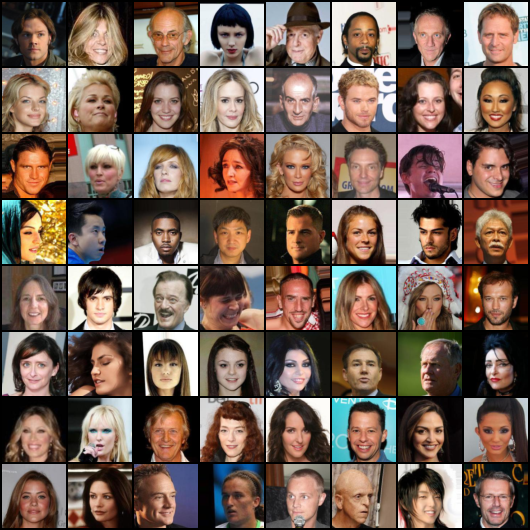

In [24]:
# Saving real images first
real_batch = next(iter(dataloader))

for images, _ in dataloader:
    save_image(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True), os.path.join(sample_dir, 'real_images.png'), nrow=8)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

In [25]:
def save_fake_images(index, latent_tensors, show=True):
  fake_images = Generator_model(latent_tensors)
  fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [26]:
fixed_latent = torch.randn(64, nz, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving fake_images-0000.png


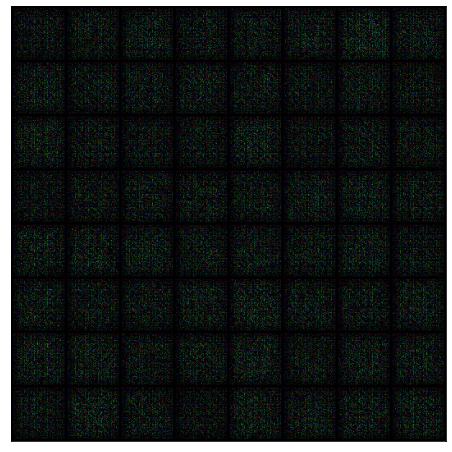

In [27]:
save_fake_images(0, fixed_latent)

In [28]:
from tqdm.notebook import tqdm, trange

In [29]:
%%time

#Training the model now and saving fake images in the folder
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in tqdm(enumerate(dataloader),total=int(len(dataloader)),desc='epoch process'):
        # Load a batch & transform to vectors
        # images = images.reshape(batch_size, -1).to(device)
        # real_cpu = images[0].to(device)
        
        # Train the discriminator
       
        for parm in critic.parameters():
          parm.data.clamp_(-clamp_num, clamp_num)

        for c in range(critic_iter):
          d_loss, real_score, fake_score = train_discriminator(images.to(device))
       
        
       # Train generator
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item()) 
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1,fixed_latent,show=False)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [0/50], Step [200/3166], d_loss: -1.5535, g_loss: 0.7410, D(x): 0.82, D(G(z)): -0.73
Epoch [0/50], Step [400/3166], d_loss: -1.3665, g_loss: 0.6538, D(x): 0.69, D(G(z)): -0.68
Epoch [0/50], Step [600/3166], d_loss: -1.4061, g_loss: 0.6793, D(x): 0.72, D(G(z)): -0.69
Epoch [0/50], Step [800/3166], d_loss: -1.4399, g_loss: 0.7057, D(x): 0.74, D(G(z)): -0.70
Epoch [0/50], Step [1000/3166], d_loss: -1.4285, g_loss: 0.6887, D(x): 0.74, D(G(z)): -0.69
Epoch [0/50], Step [1200/3166], d_loss: -1.3696, g_loss: 0.6817, D(x): 0.72, D(G(z)): -0.65
Epoch [0/50], Step [1400/3166], d_loss: -1.3001, g_loss: 0.6500, D(x): 0.68, D(G(z)): -0.62
Epoch [0/50], Step [1600/3166], d_loss: -1.3195, g_loss: 0.6332, D(x): 0.67, D(G(z)): -0.65
Epoch [0/50], Step [1800/3166], d_loss: -0.7137, g_loss: -0.1569, D(x): 0.03, D(G(z)): -0.68
Epoch [0/50], Step [2000/3166], d_loss: -1.1021, g_loss: 0.6839, D(x): 0.70, D(G(z)): -0.40
Epoch [0/50], Step [2200/3166], d_loss: -1.2572, g_loss: 0.5743, D(x): 0.61, D(G(z)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [1/50], Step [200/3166], d_loss: -1.1761, g_loss: 0.6109, D(x): 0.64, D(G(z)): -0.54
Epoch [1/50], Step [400/3166], d_loss: -1.2188, g_loss: 0.5810, D(x): 0.60, D(G(z)): -0.62
Epoch [1/50], Step [600/3166], d_loss: -0.7525, g_loss: -0.1614, D(x): 0.11, D(G(z)): -0.64
Epoch [1/50], Step [800/3166], d_loss: -0.7257, g_loss: 0.6341, D(x): 0.67, D(G(z)): -0.05
Epoch [1/50], Step [1000/3166], d_loss: -1.0457, g_loss: 0.6578, D(x): 0.69, D(G(z)): -0.36
Epoch [1/50], Step [1200/3166], d_loss: -1.1741, g_loss: 0.5733, D(x): 0.60, D(G(z)): -0.57
Epoch [1/50], Step [1400/3166], d_loss: -1.1661, g_loss: 0.6339, D(x): 0.68, D(G(z)): -0.49
Epoch [1/50], Step [1600/3166], d_loss: -1.0750, g_loss: 0.6393, D(x): 0.66, D(G(z)): -0.41
Epoch [1/50], Step [1800/3166], d_loss: -1.1603, g_loss: 0.5917, D(x): 0.61, D(G(z)): -0.56
Epoch [1/50], Step [2000/3166], d_loss: -1.1888, g_loss: 0.5900, D(x): 0.62, D(G(z)): -0.57
Epoch [1/50], Step [2200/3166], d_loss: -0.9301, g_loss: 0.2521, D(x): 0.28, D(G(z)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [2/50], Step [200/3166], d_loss: -0.7367, g_loss: 0.6292, D(x): 0.66, D(G(z)): -0.08
Epoch [2/50], Step [400/3166], d_loss: -0.8936, g_loss: 0.2466, D(x): 0.32, D(G(z)): -0.57
Epoch [2/50], Step [600/3166], d_loss: -0.8378, g_loss: 0.5990, D(x): 0.66, D(G(z)): -0.18
Epoch [2/50], Step [800/3166], d_loss: -0.9640, g_loss: 0.4023, D(x): 0.39, D(G(z)): -0.58
Epoch [2/50], Step [1000/3166], d_loss: -0.8938, g_loss: 0.3444, D(x): 0.30, D(G(z)): -0.59
Epoch [2/50], Step [1200/3166], d_loss: -1.0924, g_loss: 0.5848, D(x): 0.62, D(G(z)): -0.47
Epoch [2/50], Step [1400/3166], d_loss: -0.9018, g_loss: 0.5918, D(x): 0.63, D(G(z)): -0.28
Epoch [2/50], Step [1600/3166], d_loss: -0.9503, g_loss: 0.5486, D(x): 0.60, D(G(z)): -0.35
Epoch [2/50], Step [1800/3166], d_loss: -0.8936, g_loss: 0.5785, D(x): 0.60, D(G(z)): -0.29
Epoch [2/50], Step [2000/3166], d_loss: -0.7933, g_loss: 0.5838, D(x): 0.62, D(G(z)): -0.17
Epoch [2/50], Step [2200/3166], d_loss: -0.9352, g_loss: 0.2586, D(x): 0.36, D(G(z))

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [3/50], Step [200/3166], d_loss: -0.7499, g_loss: 0.5739, D(x): 0.58, D(G(z)): -0.17
Epoch [3/50], Step [400/3166], d_loss: -0.9277, g_loss: 0.3849, D(x): 0.47, D(G(z)): -0.46
Epoch [3/50], Step [600/3166], d_loss: -0.7525, g_loss: 0.5928, D(x): 0.61, D(G(z)): -0.14
Epoch [3/50], Step [800/3166], d_loss: -0.8994, g_loss: 0.3305, D(x): 0.34, D(G(z)): -0.56
Epoch [3/50], Step [1000/3166], d_loss: -0.7294, g_loss: 0.1303, D(x): 0.20, D(G(z)): -0.53
Epoch [3/50], Step [1200/3166], d_loss: -0.8314, g_loss: 0.5304, D(x): 0.57, D(G(z)): -0.26
Epoch [3/50], Step [1400/3166], d_loss: -0.6406, g_loss: 0.5339, D(x): 0.61, D(G(z)): -0.03
Epoch [3/50], Step [1600/3166], d_loss: -0.7729, g_loss: 0.3263, D(x): 0.26, D(G(z)): -0.51
Epoch [3/50], Step [1800/3166], d_loss: -0.7348, g_loss: 0.1157, D(x): 0.19, D(G(z)): -0.55
Epoch [3/50], Step [2000/3166], d_loss: -0.8001, g_loss: 0.2048, D(x): 0.25, D(G(z)): -0.55
Epoch [3/50], Step [2200/3166], d_loss: -0.6864, g_loss: 0.5476, D(x): 0.58, D(G(z))

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [4/50], Step [200/3166], d_loss: -0.7061, g_loss: 0.5550, D(x): 0.56, D(G(z)): -0.14
Epoch [4/50], Step [400/3166], d_loss: -0.6522, g_loss: 0.5376, D(x): 0.55, D(G(z)): -0.10
Epoch [4/50], Step [600/3166], d_loss: -0.7053, g_loss: 0.4728, D(x): 0.53, D(G(z)): -0.17
Epoch [4/50], Step [800/3166], d_loss: -0.6773, g_loss: 0.1638, D(x): 0.17, D(G(z)): -0.51
Epoch [4/50], Step [1000/3166], d_loss: -0.7314, g_loss: 0.4942, D(x): 0.55, D(G(z)): -0.18
Epoch [4/50], Step [1200/3166], d_loss: -0.7191, g_loss: 0.5372, D(x): 0.60, D(G(z)): -0.12
Epoch [4/50], Step [1400/3166], d_loss: -0.7107, g_loss: 0.4793, D(x): 0.53, D(G(z)): -0.18
Epoch [4/50], Step [1600/3166], d_loss: -0.6307, g_loss: 0.0026, D(x): 0.14, D(G(z)): -0.49
Epoch [4/50], Step [1800/3166], d_loss: -0.6666, g_loss: 0.1358, D(x): 0.14, D(G(z)): -0.53
Epoch [4/50], Step [2000/3166], d_loss: -0.7548, g_loss: 0.2554, D(x): 0.27, D(G(z)): -0.48
Epoch [4/50], Step [2200/3166], d_loss: -0.5899, g_loss: 0.0979, D(x): 0.10, D(G(z))

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [5/50], Step [200/3166], d_loss: -0.6243, g_loss: 0.5715, D(x): 0.58, D(G(z)): -0.04
Epoch [5/50], Step [400/3166], d_loss: -0.5906, g_loss: -0.0352, D(x): 0.11, D(G(z)): -0.48
Epoch [5/50], Step [600/3166], d_loss: -0.5830, g_loss: 0.5079, D(x): 0.56, D(G(z)): -0.03
Epoch [5/50], Step [800/3166], d_loss: -0.6800, g_loss: 0.4936, D(x): 0.50, D(G(z)): -0.18
Epoch [5/50], Step [1000/3166], d_loss: -0.7478, g_loss: 0.3984, D(x): 0.44, D(G(z)): -0.31
Epoch [5/50], Step [1200/3166], d_loss: -0.5474, g_loss: -0.1347, D(x): 0.03, D(G(z)): -0.52
Epoch [5/50], Step [1400/3166], d_loss: -0.6374, g_loss: 0.1190, D(x): 0.15, D(G(z)): -0.49
Epoch [5/50], Step [1600/3166], d_loss: -0.5709, g_loss: 0.0392, D(x): 0.13, D(G(z)): -0.44
Epoch [5/50], Step [1800/3166], d_loss: -0.6495, g_loss: 0.2009, D(x): 0.29, D(G(z)): -0.36
Epoch [5/50], Step [2000/3166], d_loss: -0.6925, g_loss: 0.5192, D(x): 0.56, D(G(z)): -0.13
Epoch [5/50], Step [2200/3166], d_loss: -0.5236, g_loss: -0.0818, D(x): 0.02, D(G(

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [6/50], Step [200/3166], d_loss: -0.5611, g_loss: 0.4671, D(x): 0.55, D(G(z)): -0.01
Epoch [6/50], Step [400/3166], d_loss: -0.6470, g_loss: 0.4872, D(x): 0.47, D(G(z)): -0.18
Epoch [6/50], Step [600/3166], d_loss: -0.6603, g_loss: 0.4678, D(x): 0.58, D(G(z)): -0.08
Epoch [6/50], Step [800/3166], d_loss: -0.5834, g_loss: 0.5043, D(x): 0.56, D(G(z)): -0.03
Epoch [6/50], Step [1000/3166], d_loss: -0.5440, g_loss: 0.1986, D(x): 0.10, D(G(z)): -0.44
Epoch [6/50], Step [1200/3166], d_loss: -0.6715, g_loss: 0.3358, D(x): 0.34, D(G(z)): -0.33
Epoch [6/50], Step [1400/3166], d_loss: -0.7518, g_loss: 0.0002, D(x): 0.25, D(G(z)): -0.50
Epoch [6/50], Step [1600/3166], d_loss: -0.6310, g_loss: 0.5093, D(x): 0.55, D(G(z)): -0.08
Epoch [6/50], Step [1800/3166], d_loss: -0.6425, g_loss: 0.1483, D(x): 0.14, D(G(z)): -0.50
Epoch [6/50], Step [2000/3166], d_loss: -0.5474, g_loss: 0.3467, D(x): 0.60, D(G(z)): 0.05
Epoch [6/50], Step [2200/3166], d_loss: -0.6449, g_loss: 0.3175, D(x): 0.30, D(G(z)):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [7/50], Step [200/3166], d_loss: -0.6214, g_loss: 0.4180, D(x): 0.42, D(G(z)): -0.20
Epoch [7/50], Step [400/3166], d_loss: -0.4953, g_loss: 0.3984, D(x): 0.32, D(G(z)): -0.18
Epoch [7/50], Step [600/3166], d_loss: -0.6156, g_loss: 0.2404, D(x): 0.15, D(G(z)): -0.46
Epoch [7/50], Step [800/3166], d_loss: -0.5964, g_loss: 0.2767, D(x): 0.34, D(G(z)): -0.26
Epoch [7/50], Step [1000/3166], d_loss: -0.4915, g_loss: 0.5312, D(x): 0.54, D(G(z)): 0.04
Epoch [7/50], Step [1200/3166], d_loss: -0.7567, g_loss: 0.2961, D(x): 0.39, D(G(z)): -0.37
Epoch [7/50], Step [1400/3166], d_loss: -0.3658, g_loss: 0.3876, D(x): 0.53, D(G(z)): 0.16
Epoch [7/50], Step [1600/3166], d_loss: -0.6832, g_loss: 0.4733, D(x): 0.52, D(G(z)): -0.16
Epoch [7/50], Step [1800/3166], d_loss: -0.7748, g_loss: 0.3450, D(x): 0.51, D(G(z)): -0.27
Epoch [7/50], Step [2000/3166], d_loss: -0.5565, g_loss: -0.0565, D(x): 0.08, D(G(z)): -0.48
Epoch [7/50], Step [2200/3166], d_loss: -0.4493, g_loss: 0.1094, D(x): 0.08, D(G(z)):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [8/50], Step [200/3166], d_loss: -0.4872, g_loss: -0.0732, D(x): 0.02, D(G(z)): -0.47
Epoch [8/50], Step [400/3166], d_loss: -0.5688, g_loss: 0.2895, D(x): 0.06, D(G(z)): -0.51
Epoch [8/50], Step [600/3166], d_loss: -0.6855, g_loss: 0.5556, D(x): 0.52, D(G(z)): -0.16
Epoch [8/50], Step [800/3166], d_loss: -0.5516, g_loss: -0.0671, D(x): 0.11, D(G(z)): -0.44
Epoch [8/50], Step [1000/3166], d_loss: -0.7258, g_loss: 0.4964, D(x): 0.62, D(G(z)): -0.11
Epoch [8/50], Step [1200/3166], d_loss: -0.5206, g_loss: 0.3330, D(x): 0.28, D(G(z)): -0.24
Epoch [8/50], Step [1400/3166], d_loss: -0.8352, g_loss: 0.3514, D(x): 0.35, D(G(z)): -0.49
Epoch [8/50], Step [1600/3166], d_loss: -0.8284, g_loss: 0.4549, D(x): 0.65, D(G(z)): -0.18
Epoch [8/50], Step [1800/3166], d_loss: -0.2290, g_loss: 0.3830, D(x): 0.65, D(G(z)): 0.42
Epoch [8/50], Step [2000/3166], d_loss: -0.4829, g_loss: 0.1057, D(x): 0.10, D(G(z)): -0.38
Epoch [8/50], Step [2200/3166], d_loss: -0.4972, g_loss: -0.2306, D(x): 0.04, D(G(z

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [9/50], Step [200/3166], d_loss: -0.5698, g_loss: -0.1442, D(x): 0.21, D(G(z)): -0.36
Epoch [9/50], Step [400/3166], d_loss: -0.7403, g_loss: -0.0918, D(x): 0.21, D(G(z)): -0.53
Epoch [9/50], Step [600/3166], d_loss: -0.5056, g_loss: 0.2291, D(x): 0.10, D(G(z)): -0.40
Epoch [9/50], Step [800/3166], d_loss: -0.4394, g_loss: 0.2572, D(x): 0.24, D(G(z)): -0.19
Epoch [9/50], Step [1000/3166], d_loss: -0.7784, g_loss: 0.2675, D(x): 0.38, D(G(z)): -0.40
Epoch [9/50], Step [1200/3166], d_loss: -0.6317, g_loss: 0.3390, D(x): 0.38, D(G(z)): -0.25
Epoch [9/50], Step [1400/3166], d_loss: -0.8888, g_loss: 0.3947, D(x): 0.32, D(G(z)): -0.57
Epoch [9/50], Step [1600/3166], d_loss: -1.0811, g_loss: 0.5592, D(x): 0.59, D(G(z)): -0.50
Epoch [9/50], Step [1800/3166], d_loss: -0.3740, g_loss: 0.5167, D(x): 0.56, D(G(z)): 0.19
Epoch [9/50], Step [2000/3166], d_loss: -0.4585, g_loss: -0.0057, D(x): 0.20, D(G(z)): -0.26
Epoch [9/50], Step [2200/3166], d_loss: -0.1815, g_loss: 0.5030, D(x): 0.47, D(G(z

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [10/50], Step [200/3166], d_loss: -0.4531, g_loss: 0.2984, D(x): 0.33, D(G(z)): -0.12
Epoch [10/50], Step [400/3166], d_loss: -0.6648, g_loss: -0.0171, D(x): 0.14, D(G(z)): -0.52
Epoch [10/50], Step [600/3166], d_loss: -0.2347, g_loss: 0.0510, D(x): 0.39, D(G(z)): 0.16
Epoch [10/50], Step [800/3166], d_loss: -0.5624, g_loss: -0.0358, D(x): 0.13, D(G(z)): -0.44
Epoch [10/50], Step [1000/3166], d_loss: -0.6084, g_loss: 0.2375, D(x): 0.24, D(G(z)): -0.37
Epoch [10/50], Step [1200/3166], d_loss: -0.4547, g_loss: 0.1836, D(x): 0.12, D(G(z)): -0.34
Epoch [10/50], Step [1400/3166], d_loss: -0.7237, g_loss: 0.4388, D(x): 0.36, D(G(z)): -0.36
Epoch [10/50], Step [1600/3166], d_loss: -0.4235, g_loss: 0.3650, D(x): 0.57, D(G(z)): 0.15
Epoch [10/50], Step [1800/3166], d_loss: -0.4394, g_loss: -0.0403, D(x): -0.02, D(G(z)): -0.46
Epoch [10/50], Step [2000/3166], d_loss: -0.7023, g_loss: -0.1708, D(x): 0.24, D(G(z)): -0.46
Epoch [10/50], Step [2200/3166], d_loss: -0.4560, g_loss: 0.1556, D(x):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [11/50], Step [200/3166], d_loss: -0.5327, g_loss: -0.3312, D(x): -0.02, D(G(z)): -0.55
Epoch [11/50], Step [400/3166], d_loss: -0.5826, g_loss: 0.4889, D(x): 0.58, D(G(z)): -0.00
Epoch [11/50], Step [600/3166], d_loss: -0.5436, g_loss: -0.0694, D(x): 0.14, D(G(z)): -0.41
Epoch [11/50], Step [800/3166], d_loss: -0.5789, g_loss: 0.2134, D(x): 0.23, D(G(z)): -0.35
Epoch [11/50], Step [1000/3166], d_loss: -0.2601, g_loss: -0.0195, D(x): 0.19, D(G(z)): -0.07
Epoch [11/50], Step [1200/3166], d_loss: -0.0959, g_loss: 0.4731, D(x): 0.49, D(G(z)): 0.40
Epoch [11/50], Step [1400/3166], d_loss: -0.0412, g_loss: 0.5690, D(x): -0.50, D(G(z)): -0.54
Epoch [11/50], Step [1600/3166], d_loss: -0.4268, g_loss: -0.0083, D(x): 0.00, D(G(z)): -0.43
Epoch [11/50], Step [1800/3166], d_loss: -0.6482, g_loss: -0.2102, D(x): 0.04, D(G(z)): -0.61
Epoch [11/50], Step [2000/3166], d_loss: -0.2858, g_loss: 0.3838, D(x): 0.60, D(G(z)): 0.32
Epoch [11/50], Step [2200/3166], d_loss: -0.2907, g_loss: -0.1154, D(

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [12/50], Step [200/3166], d_loss: -0.4255, g_loss: -0.1424, D(x): -0.08, D(G(z)): -0.50
Epoch [12/50], Step [400/3166], d_loss: -0.1690, g_loss: -0.1882, D(x): 0.48, D(G(z)): 0.31
Epoch [12/50], Step [600/3166], d_loss: -0.3630, g_loss: 0.4482, D(x): 0.34, D(G(z)): -0.02
Epoch [12/50], Step [800/3166], d_loss: -0.3665, g_loss: 0.2521, D(x): 0.19, D(G(z)): -0.18
Epoch [12/50], Step [1000/3166], d_loss: -0.4744, g_loss: 0.0584, D(x): 0.21, D(G(z)): -0.27
Epoch [12/50], Step [1200/3166], d_loss: -0.5062, g_loss: 0.5499, D(x): 0.60, D(G(z)): 0.09
Epoch [12/50], Step [1400/3166], d_loss: -0.4700, g_loss: 0.1559, D(x): 0.14, D(G(z)): -0.33
Epoch [12/50], Step [1600/3166], d_loss: -0.4618, g_loss: -0.3196, D(x): 0.01, D(G(z)): -0.45
Epoch [12/50], Step [1800/3166], d_loss: -0.5985, g_loss: 0.2077, D(x): 0.22, D(G(z)): -0.37
Epoch [12/50], Step [2000/3166], d_loss: -0.0627, g_loss: -0.0590, D(x): 0.22, D(G(z)): 0.16
Epoch [12/50], Step [2200/3166], d_loss: -0.4393, g_loss: 0.4365, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [13/50], Step [200/3166], d_loss: -0.6769, g_loss: 0.0794, D(x): 0.25, D(G(z)): -0.43
Epoch [13/50], Step [400/3166], d_loss: -0.4184, g_loss: 0.2985, D(x): 0.27, D(G(z)): -0.15
Epoch [13/50], Step [600/3166], d_loss: -0.5591, g_loss: 0.0322, D(x): 0.19, D(G(z)): -0.37
Epoch [13/50], Step [800/3166], d_loss: -0.4544, g_loss: 0.5309, D(x): 0.61, D(G(z)): 0.16
Epoch [13/50], Step [1000/3166], d_loss: -0.3962, g_loss: 0.5163, D(x): 0.43, D(G(z)): 0.03
Epoch [13/50], Step [1200/3166], d_loss: -0.2208, g_loss: 0.0723, D(x): 0.27, D(G(z)): 0.05
Epoch [13/50], Step [1400/3166], d_loss: -0.3989, g_loss: 0.3587, D(x): 0.29, D(G(z)): -0.11
Epoch [13/50], Step [1600/3166], d_loss: -0.4147, g_loss: 0.4008, D(x): 0.42, D(G(z)): 0.00
Epoch [13/50], Step [1800/3166], d_loss: -0.4991, g_loss: -0.2291, D(x): 0.17, D(G(z)): -0.33
Epoch [13/50], Step [2000/3166], d_loss: -0.1843, g_loss: 0.2936, D(x): -0.34, D(G(z)): -0.53
Epoch [13/50], Step [2200/3166], d_loss: -0.5149, g_loss: 0.3456, D(x): 0.26

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [14/50], Step [200/3166], d_loss: -0.3582, g_loss: 0.1098, D(x): 0.17, D(G(z)): -0.19
Epoch [14/50], Step [400/3166], d_loss: -0.0248, g_loss: 0.6038, D(x): -0.58, D(G(z)): -0.60
Epoch [14/50], Step [600/3166], d_loss: -0.0222, g_loss: 0.5482, D(x): -0.49, D(G(z)): -0.51
Epoch [14/50], Step [800/3166], d_loss: -0.3249, g_loss: 0.0322, D(x): -0.13, D(G(z)): -0.46
Epoch [14/50], Step [1000/3166], d_loss: -0.4002, g_loss: -0.0006, D(x): 0.15, D(G(z)): -0.25
Epoch [14/50], Step [1200/3166], d_loss: -0.4632, g_loss: 0.1955, D(x): 0.37, D(G(z)): -0.09
Epoch [14/50], Step [1400/3166], d_loss: -0.4296, g_loss: 0.5320, D(x): 0.57, D(G(z)): 0.14
Epoch [14/50], Step [1600/3166], d_loss: -0.3671, g_loss: 0.3581, D(x): 0.48, D(G(z)): 0.11
Epoch [14/50], Step [1800/3166], d_loss: -0.0902, g_loss: -0.4375, D(x): 0.56, D(G(z)): 0.47
Epoch [14/50], Step [2000/3166], d_loss: -0.0961, g_loss: -0.3921, D(x): 0.52, D(G(z)): 0.43
Epoch [14/50], Step [2200/3166], d_loss: -0.2563, g_loss: 0.2199, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [15/50], Step [200/3166], d_loss: -0.3056, g_loss: 0.3808, D(x): 0.36, D(G(z)): 0.06
Epoch [15/50], Step [400/3166], d_loss: -0.3990, g_loss: -0.4787, D(x): -0.03, D(G(z)): -0.43
Epoch [15/50], Step [600/3166], d_loss: -0.3358, g_loss: 0.4438, D(x): 0.44, D(G(z)): 0.10
Epoch [15/50], Step [800/3166], d_loss: -0.0168, g_loss: 0.5850, D(x): -0.58, D(G(z)): -0.60
Epoch [15/50], Step [1000/3166], d_loss: -0.3173, g_loss: -0.1176, D(x): 0.11, D(G(z)): -0.21
Epoch [15/50], Step [1200/3166], d_loss: -0.5789, g_loss: 0.5445, D(x): 0.55, D(G(z)): -0.03
Epoch [15/50], Step [1400/3166], d_loss: -0.1198, g_loss: -0.3222, D(x): 0.55, D(G(z)): 0.43
Epoch [15/50], Step [1600/3166], d_loss: -0.0603, g_loss: -0.1954, D(x): 0.40, D(G(z)): 0.34
Epoch [15/50], Step [1800/3166], d_loss: 0.0061, g_loss: -0.1337, D(x): 0.00, D(G(z)): 0.01
Epoch [15/50], Step [2000/3166], d_loss: -0.3103, g_loss: -0.0768, D(x): -0.15, D(G(z)): -0.46
Epoch [15/50], Step [2200/3166], d_loss: -0.1116, g_loss: -0.4216, D(x)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [16/50], Step [200/3166], d_loss: -0.0047, g_loss: 0.3888, D(x): -0.28, D(G(z)): -0.29
Epoch [16/50], Step [400/3166], d_loss: -0.4058, g_loss: 0.0746, D(x): 0.23, D(G(z)): -0.18
Epoch [16/50], Step [600/3166], d_loss: -0.4058, g_loss: -0.2936, D(x): 0.06, D(G(z)): -0.35
Epoch [16/50], Step [800/3166], d_loss: -0.1170, g_loss: 0.4824, D(x): -0.37, D(G(z)): -0.49
Epoch [16/50], Step [1000/3166], d_loss: -0.1022, g_loss: 0.4435, D(x): -0.40, D(G(z)): -0.50
Epoch [16/50], Step [1200/3166], d_loss: -0.1476, g_loss: 0.3404, D(x): -0.23, D(G(z)): -0.37
Epoch [16/50], Step [1400/3166], d_loss: -0.2139, g_loss: -0.0324, D(x): -0.02, D(G(z)): -0.24
Epoch [16/50], Step [1600/3166], d_loss: -0.0982, g_loss: -0.1042, D(x): 0.27, D(G(z)): 0.17
Epoch [16/50], Step [1800/3166], d_loss: -0.3645, g_loss: -0.2405, D(x): 0.15, D(G(z)): -0.21
Epoch [16/50], Step [2000/3166], d_loss: -0.0059, g_loss: 0.5747, D(x): -0.57, D(G(z)): -0.57
Epoch [16/50], Step [2200/3166], d_loss: -0.1194, g_loss: 0.4699,

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [17/50], Step [200/3166], d_loss: -0.2284, g_loss: 0.0189, D(x): 0.22, D(G(z)): -0.01
Epoch [17/50], Step [400/3166], d_loss: 0.4131, g_loss: 0.4564, D(x): -0.37, D(G(z)): 0.04
Epoch [17/50], Step [600/3166], d_loss: -0.1857, g_loss: 0.3040, D(x): -0.13, D(G(z)): -0.32
Epoch [17/50], Step [800/3166], d_loss: -0.2398, g_loss: 0.1911, D(x): 0.25, D(G(z)): 0.01
Epoch [17/50], Step [1000/3166], d_loss: -0.0397, g_loss: 0.4198, D(x): -0.41, D(G(z)): -0.44
Epoch [17/50], Step [1200/3166], d_loss: -0.0196, g_loss: 0.4677, D(x): -0.48, D(G(z)): -0.50
Epoch [17/50], Step [1400/3166], d_loss: 0.0236, g_loss: 0.5625, D(x): -0.56, D(G(z)): -0.54
Epoch [17/50], Step [1600/3166], d_loss: -0.1936, g_loss: 0.2871, D(x): 0.14, D(G(z)): -0.06
Epoch [17/50], Step [1800/3166], d_loss: -0.5215, g_loss: 0.4455, D(x): 0.16, D(G(z)): -0.36
Epoch [17/50], Step [2000/3166], d_loss: -0.7768, g_loss: -0.5212, D(x): 0.34, D(G(z)): -0.44
Epoch [17/50], Step [2200/3166], d_loss: -0.0694, g_loss: -0.5234, D(x):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [18/50], Step [200/3166], d_loss: 0.0039, g_loss: 0.4409, D(x): -0.47, D(G(z)): -0.47
Epoch [18/50], Step [400/3166], d_loss: -0.1086, g_loss: 0.2374, D(x): -0.13, D(G(z)): -0.24
Epoch [18/50], Step [600/3166], d_loss: -0.4073, g_loss: 0.2134, D(x): 0.26, D(G(z)): -0.15
Epoch [18/50], Step [800/3166], d_loss: -0.0369, g_loss: 0.5233, D(x): -0.49, D(G(z)): -0.52
Epoch [18/50], Step [1000/3166], d_loss: -0.3063, g_loss: 0.3285, D(x): 0.28, D(G(z)): -0.03
Epoch [18/50], Step [1200/3166], d_loss: -0.1075, g_loss: 0.2329, D(x): -0.15, D(G(z)): -0.26
Epoch [18/50], Step [1400/3166], d_loss: -0.0266, g_loss: 0.5503, D(x): -0.54, D(G(z)): -0.56
Epoch [18/50], Step [1600/3166], d_loss: -0.1739, g_loss: 0.1765, D(x): 0.40, D(G(z)): 0.23
Epoch [18/50], Step [1800/3166], d_loss: -0.0389, g_loss: 0.5747, D(x): -0.57, D(G(z)): -0.61
Epoch [18/50], Step [2000/3166], d_loss: -0.3021, g_loss: 0.3489, D(x): 0.42, D(G(z)): 0.12
Epoch [18/50], Step [2200/3166], d_loss: -0.5313, g_loss: -0.3288, D(x)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [19/50], Step [200/3166], d_loss: -0.1207, g_loss: -0.1124, D(x): 0.31, D(G(z)): 0.19
Epoch [19/50], Step [400/3166], d_loss: -0.0102, g_loss: 0.3159, D(x): -0.26, D(G(z)): -0.27
Epoch [19/50], Step [600/3166], d_loss: -0.0614, g_loss: 0.0341, D(x): 0.04, D(G(z)): -0.02
Epoch [19/50], Step [800/3166], d_loss: -0.1986, g_loss: 0.2683, D(x): 0.34, D(G(z)): 0.14
Epoch [19/50], Step [1000/3166], d_loss: -0.0676, g_loss: 0.1877, D(x): 0.02, D(G(z)): -0.05
Epoch [19/50], Step [1200/3166], d_loss: -0.0330, g_loss: 0.1217, D(x): -0.03, D(G(z)): -0.06
Epoch [19/50], Step [1400/3166], d_loss: -0.5385, g_loss: 0.2197, D(x): 0.14, D(G(z)): -0.40
Epoch [19/50], Step [1600/3166], d_loss: 0.1780, g_loss: 0.2621, D(x): -0.25, D(G(z)): -0.07
Epoch [19/50], Step [1800/3166], d_loss: -0.0825, g_loss: 0.4735, D(x): -0.44, D(G(z)): -0.53
Epoch [19/50], Step [2000/3166], d_loss: -0.0636, g_loss: 0.4825, D(x): -0.48, D(G(z)): -0.54
Epoch [19/50], Step [2200/3166], d_loss: -0.2678, g_loss: 0.3607, D(x):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [20/50], Step [200/3166], d_loss: -0.2952, g_loss: -0.0992, D(x): 0.12, D(G(z)): -0.17
Epoch [20/50], Step [400/3166], d_loss: -0.4007, g_loss: 0.2882, D(x): 0.19, D(G(z)): -0.21
Epoch [20/50], Step [600/3166], d_loss: -0.0646, g_loss: -0.2908, D(x): 0.38, D(G(z)): 0.32
Epoch [20/50], Step [800/3166], d_loss: -0.1168, g_loss: 0.2668, D(x): -0.28, D(G(z)): -0.39
Epoch [20/50], Step [1000/3166], d_loss: 0.0414, g_loss: 0.6379, D(x): -0.62, D(G(z)): -0.58
Epoch [20/50], Step [1200/3166], d_loss: -0.0296, g_loss: -0.3773, D(x): 0.48, D(G(z)): 0.45
Epoch [20/50], Step [1400/3166], d_loss: 0.0139, g_loss: 0.5597, D(x): -0.53, D(G(z)): -0.51
Epoch [20/50], Step [1600/3166], d_loss: -0.6739, g_loss: 0.3867, D(x): 0.11, D(G(z)): -0.56
Epoch [20/50], Step [1800/3166], d_loss: -0.0604, g_loss: 0.0032, D(x): -0.05, D(G(z)): -0.11
Epoch [20/50], Step [2000/3166], d_loss: -0.5233, g_loss: -0.1203, D(x): 0.32, D(G(z)): -0.21
Epoch [20/50], Step [2200/3166], d_loss: -0.4928, g_loss: -0.4155, D(x

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [21/50], Step [200/3166], d_loss: -0.4386, g_loss: 0.2658, D(x): 0.24, D(G(z)): -0.20
Epoch [21/50], Step [400/3166], d_loss: 0.0787, g_loss: 0.4707, D(x): -0.36, D(G(z)): -0.29
Epoch [21/50], Step [600/3166], d_loss: -0.3006, g_loss: -0.2621, D(x): 0.53, D(G(z)): 0.23
Epoch [21/50], Step [800/3166], d_loss: -0.0506, g_loss: 0.5467, D(x): -0.52, D(G(z)): -0.57
Epoch [21/50], Step [1000/3166], d_loss: -0.1721, g_loss: 0.1740, D(x): 0.26, D(G(z)): 0.09
Epoch [21/50], Step [1200/3166], d_loss: -0.6611, g_loss: 0.0337, D(x): 0.31, D(G(z)): -0.35
Epoch [21/50], Step [1400/3166], d_loss: -0.0894, g_loss: -0.0975, D(x): 0.22, D(G(z)): 0.14
Epoch [21/50], Step [1600/3166], d_loss: -0.4170, g_loss: -0.0626, D(x): 0.21, D(G(z)): -0.21
Epoch [21/50], Step [1800/3166], d_loss: -0.0411, g_loss: -0.4708, D(x): 0.57, D(G(z)): 0.53
Epoch [21/50], Step [2000/3166], d_loss: -0.1489, g_loss: -0.3824, D(x): 0.48, D(G(z)): 0.33
Epoch [21/50], Step [2200/3166], d_loss: -0.2652, g_loss: 0.3080, D(x): -

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [22/50], Step [200/3166], d_loss: 0.0389, g_loss: 0.4929, D(x): -0.39, D(G(z)): -0.36
Epoch [22/50], Step [400/3166], d_loss: -0.0393, g_loss: 0.3444, D(x): -0.26, D(G(z)): -0.30
Epoch [22/50], Step [600/3166], d_loss: -0.7893, g_loss: -0.3206, D(x): 0.29, D(G(z)): -0.50
Epoch [22/50], Step [800/3166], d_loss: -0.2295, g_loss: 0.0972, D(x): 0.29, D(G(z)): 0.06
Epoch [22/50], Step [1000/3166], d_loss: -0.4470, g_loss: -0.2037, D(x): -0.18, D(G(z)): -0.63
Epoch [22/50], Step [1200/3166], d_loss: -0.0143, g_loss: 0.5922, D(x): -0.56, D(G(z)): -0.57
Epoch [22/50], Step [1400/3166], d_loss: -0.5013, g_loss: 0.3834, D(x): 0.41, D(G(z)): -0.09
Epoch [22/50], Step [1600/3166], d_loss: -0.1564, g_loss: -0.2555, D(x): 0.43, D(G(z)): 0.28
Epoch [22/50], Step [1800/3166], d_loss: -0.0639, g_loss: 0.5443, D(x): -0.48, D(G(z)): -0.55
Epoch [22/50], Step [2000/3166], d_loss: -0.0660, g_loss: 0.0046, D(x): 0.27, D(G(z)): 0.20
Epoch [22/50], Step [2200/3166], d_loss: -0.9814, g_loss: 0.5935, D(x)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [23/50], Step [200/3166], d_loss: -1.2685, g_loss: 0.1305, D(x): 0.68, D(G(z)): -0.58
Epoch [23/50], Step [400/3166], d_loss: -0.0517, g_loss: 0.3224, D(x): 0.13, D(G(z)): 0.08
Epoch [23/50], Step [600/3166], d_loss: -0.2631, g_loss: 0.4266, D(x): -0.16, D(G(z)): -0.43
Epoch [23/50], Step [800/3166], d_loss: 0.0018, g_loss: -0.5908, D(x): 0.60, D(G(z)): 0.61
Epoch [23/50], Step [1000/3166], d_loss: 0.0460, g_loss: -0.6209, D(x): 0.57, D(G(z)): 0.61
Epoch [23/50], Step [1200/3166], d_loss: -0.0273, g_loss: 0.5081, D(x): -0.46, D(G(z)): -0.48
Epoch [23/50], Step [1400/3166], d_loss: -0.0924, g_loss: 0.3830, D(x): -0.06, D(G(z)): -0.16
Epoch [23/50], Step [1600/3166], d_loss: -0.4487, g_loss: 0.4609, D(x): 0.66, D(G(z)): 0.21
Epoch [23/50], Step [1800/3166], d_loss: 0.0174, g_loss: 0.5143, D(x): -0.50, D(G(z)): -0.48
Epoch [23/50], Step [2000/3166], d_loss: -0.1141, g_loss: -0.3198, D(x): 0.56, D(G(z)): 0.45
Epoch [23/50], Step [2200/3166], d_loss: -0.1865, g_loss: -0.0574, D(x): 0.

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [24/50], Step [200/3166], d_loss: -0.4926, g_loss: -0.4703, D(x): -0.07, D(G(z)): -0.56
Epoch [24/50], Step [400/3166], d_loss: -0.0240, g_loss: -0.0762, D(x): 0.24, D(G(z)): 0.22
Epoch [24/50], Step [600/3166], d_loss: -0.0415, g_loss: 0.5322, D(x): -0.49, D(G(z)): -0.54
Epoch [24/50], Step [800/3166], d_loss: -0.3824, g_loss: -0.1397, D(x): 0.14, D(G(z)): -0.24
Epoch [24/50], Step [1000/3166], d_loss: -0.0334, g_loss: -0.1811, D(x): 0.18, D(G(z)): 0.15
Epoch [24/50], Step [1200/3166], d_loss: -0.8843, g_loss: -0.3685, D(x): 0.24, D(G(z)): -0.64
Epoch [24/50], Step [1400/3166], d_loss: -0.0145, g_loss: 0.4343, D(x): -0.40, D(G(z)): -0.41
Epoch [24/50], Step [1600/3166], d_loss: -0.6444, g_loss: 0.6622, D(x): 0.68, D(G(z)): 0.04
Epoch [24/50], Step [1800/3166], d_loss: -0.5946, g_loss: 0.3722, D(x): 0.23, D(G(z)): -0.37
Epoch [24/50], Step [2000/3166], d_loss: 0.0427, g_loss: -0.4533, D(x): 0.46, D(G(z)): 0.50
Epoch [24/50], Step [2200/3166], d_loss: -0.5481, g_loss: 0.1916, D(x)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [25/50], Step [200/3166], d_loss: -1.2052, g_loss: 0.5876, D(x): 0.67, D(G(z)): -0.53
Epoch [25/50], Step [400/3166], d_loss: -0.2051, g_loss: -0.3014, D(x): 0.54, D(G(z)): 0.33
Epoch [25/50], Step [600/3166], d_loss: -0.0861, g_loss: -0.4491, D(x): 0.58, D(G(z)): 0.50
Epoch [25/50], Step [800/3166], d_loss: -0.1925, g_loss: 0.4115, D(x): 0.18, D(G(z)): -0.01
Epoch [25/50], Step [1000/3166], d_loss: -0.1868, g_loss: -0.1121, D(x): 0.39, D(G(z)): 0.20
Epoch [25/50], Step [1200/3166], d_loss: -0.1095, g_loss: 0.5824, D(x): -0.45, D(G(z)): -0.56
Epoch [25/50], Step [1400/3166], d_loss: 0.1144, g_loss: 0.6374, D(x): -0.62, D(G(z)): -0.51
Epoch [25/50], Step [1600/3166], d_loss: -1.2858, g_loss: 0.6691, D(x): 0.65, D(G(z)): -0.63
Epoch [25/50], Step [1800/3166], d_loss: -0.1174, g_loss: -0.4710, D(x): 0.58, D(G(z)): 0.47
Epoch [25/50], Step [2000/3166], d_loss: -0.3548, g_loss: 0.5069, D(x): 0.20, D(G(z)): -0.16
Epoch [25/50], Step [2200/3166], d_loss: -0.0103, g_loss: -0.6467, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [26/50], Step [200/3166], d_loss: -0.3762, g_loss: -0.0371, D(x): -0.09, D(G(z)): -0.47
Epoch [26/50], Step [400/3166], d_loss: -0.1773, g_loss: 0.5652, D(x): -0.46, D(G(z)): -0.64
Epoch [26/50], Step [600/3166], d_loss: -1.3592, g_loss: 0.7390, D(x): 0.72, D(G(z)): -0.64
Epoch [26/50], Step [800/3166], d_loss: -0.0466, g_loss: 0.6446, D(x): -0.59, D(G(z)): -0.64
Epoch [26/50], Step [1000/3166], d_loss: -0.2030, g_loss: 0.2394, D(x): 0.25, D(G(z)): 0.05
Epoch [26/50], Step [1200/3166], d_loss: 0.0010, g_loss: -0.5976, D(x): 0.58, D(G(z)): 0.58
Epoch [26/50], Step [1400/3166], d_loss: -0.1618, g_loss: -0.4045, D(x): 0.58, D(G(z)): 0.42
Epoch [26/50], Step [1600/3166], d_loss: -0.0288, g_loss: 0.6322, D(x): -0.56, D(G(z)): -0.59
Epoch [26/50], Step [1800/3166], d_loss: -0.3440, g_loss: -0.3803, D(x): -0.02, D(G(z)): -0.36
Epoch [26/50], Step [2000/3166], d_loss: -0.2012, g_loss: 0.4665, D(x): -0.34, D(G(z)): -0.54
Epoch [26/50], Step [2200/3166], d_loss: -0.0064, g_loss: 0.3701, D(

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [27/50], Step [200/3166], d_loss: -0.0832, g_loss: -0.3581, D(x): 0.56, D(G(z)): 0.48
Epoch [27/50], Step [400/3166], d_loss: -0.3892, g_loss: -0.5679, D(x): 0.00, D(G(z)): -0.39
Epoch [27/50], Step [600/3166], d_loss: -0.1025, g_loss: 0.2223, D(x): -0.13, D(G(z)): -0.24
Epoch [27/50], Step [800/3166], d_loss: -0.1859, g_loss: 0.3067, D(x): 0.32, D(G(z)): 0.13
Epoch [27/50], Step [1000/3166], d_loss: -0.4387, g_loss: 0.4999, D(x): -0.13, D(G(z)): -0.57
Epoch [27/50], Step [1200/3166], d_loss: -1.2905, g_loss: 0.1993, D(x): 0.61, D(G(z)): -0.68
Epoch [27/50], Step [1400/3166], d_loss: -0.0366, g_loss: 0.6312, D(x): -0.60, D(G(z)): -0.63
Epoch [27/50], Step [1600/3166], d_loss: -0.3018, g_loss: 0.4693, D(x): 0.41, D(G(z)): 0.11
Epoch [27/50], Step [1800/3166], d_loss: -0.1395, g_loss: 0.3424, D(x): 0.35, D(G(z)): 0.21
Epoch [27/50], Step [2000/3166], d_loss: -0.0856, g_loss: -0.3501, D(x): 0.32, D(G(z)): 0.23
Epoch [27/50], Step [2200/3166], d_loss: -0.1720, g_loss: 0.3104, D(x): -

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [28/50], Step [200/3166], d_loss: -0.0486, g_loss: 0.6304, D(x): -0.56, D(G(z)): -0.61
Epoch [28/50], Step [400/3166], d_loss: -0.4809, g_loss: 0.6249, D(x): 0.65, D(G(z)): 0.17
Epoch [28/50], Step [600/3166], d_loss: -0.6215, g_loss: -0.5680, D(x): 0.08, D(G(z)): -0.54
Epoch [28/50], Step [800/3166], d_loss: 0.0133, g_loss: -0.4652, D(x): 0.43, D(G(z)): 0.45
Epoch [28/50], Step [1000/3166], d_loss: -0.0212, g_loss: 0.3464, D(x): -0.08, D(G(z)): -0.10
Epoch [28/50], Step [1200/3166], d_loss: -0.1188, g_loss: 0.4273, D(x): -0.33, D(G(z)): -0.45
Epoch [28/50], Step [1400/3166], d_loss: -0.1694, g_loss: 0.2815, D(x): 0.01, D(G(z)): -0.16
Epoch [28/50], Step [1600/3166], d_loss: 0.0174, g_loss: -0.6315, D(x): 0.63, D(G(z)): 0.65
Epoch [28/50], Step [1800/3166], d_loss: -0.3792, g_loss: 0.2304, D(x): -0.04, D(G(z)): -0.42
Epoch [28/50], Step [2000/3166], d_loss: -0.6124, g_loss: 0.4564, D(x): 0.31, D(G(z)): -0.31
Epoch [28/50], Step [2200/3166], d_loss: -0.7818, g_loss: 0.3727, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [29/50], Step [200/3166], d_loss: -0.0202, g_loss: -0.5158, D(x): 0.54, D(G(z)): 0.52
Epoch [29/50], Step [400/3166], d_loss: 0.0350, g_loss: -0.6806, D(x): 0.64, D(G(z)): 0.68
Epoch [29/50], Step [600/3166], d_loss: -0.6226, g_loss: 0.5472, D(x): 0.52, D(G(z)): -0.10
Epoch [29/50], Step [800/3166], d_loss: -0.0262, g_loss: 0.3200, D(x): -0.09, D(G(z)): -0.12
Epoch [29/50], Step [1000/3166], d_loss: -0.1568, g_loss: 0.0835, D(x): 0.32, D(G(z)): 0.16
Epoch [29/50], Step [1200/3166], d_loss: -0.5593, g_loss: -0.4265, D(x): 0.07, D(G(z)): -0.49
Epoch [29/50], Step [1400/3166], d_loss: -0.0091, g_loss: 0.5909, D(x): -0.61, D(G(z)): -0.62
Epoch [29/50], Step [1600/3166], d_loss: -0.6748, g_loss: 0.2801, D(x): 0.58, D(G(z)): -0.10
Epoch [29/50], Step [1800/3166], d_loss: -1.2216, g_loss: -0.6494, D(x): 0.65, D(G(z)): -0.57
Epoch [29/50], Step [2000/3166], d_loss: 0.0628, g_loss: 0.6668, D(x): -0.65, D(G(z)): -0.59
Epoch [29/50], Step [2200/3166], d_loss: -0.0059, g_loss: -0.4810, D(x):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [30/50], Step [200/3166], d_loss: -0.1606, g_loss: -0.0970, D(x): 0.36, D(G(z)): 0.20
Epoch [30/50], Step [400/3166], d_loss: -0.7948, g_loss: -0.2847, D(x): 0.30, D(G(z)): -0.49
Epoch [30/50], Step [600/3166], d_loss: -0.3377, g_loss: 0.4503, D(x): 0.41, D(G(z)): 0.07
Epoch [30/50], Step [800/3166], d_loss: -0.3695, g_loss: 0.6247, D(x): 0.46, D(G(z)): 0.09
Epoch [30/50], Step [1000/3166], d_loss: 0.2461, g_loss: 0.3236, D(x): -0.22, D(G(z)): 0.02
Epoch [30/50], Step [1200/3166], d_loss: -0.0979, g_loss: -0.4730, D(x): 0.61, D(G(z)): 0.52
Epoch [30/50], Step [1400/3166], d_loss: -0.0736, g_loss: -0.3383, D(x): 0.44, D(G(z)): 0.36
Epoch [30/50], Step [1600/3166], d_loss: -0.0595, g_loss: 0.2072, D(x): -0.19, D(G(z)): -0.25
Epoch [30/50], Step [1800/3166], d_loss: -0.0911, g_loss: 0.4222, D(x): -0.42, D(G(z)): -0.51
Epoch [30/50], Step [2000/3166], d_loss: -0.0467, g_loss: -0.3743, D(x): 0.64, D(G(z)): 0.59
Epoch [30/50], Step [2200/3166], d_loss: -0.1474, g_loss: -0.4104, D(x): 0

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [31/50], Step [200/3166], d_loss: -0.0567, g_loss: 0.4208, D(x): -0.38, D(G(z)): -0.43
Epoch [31/50], Step [400/3166], d_loss: -0.0700, g_loss: 0.1789, D(x): 0.42, D(G(z)): 0.35
Epoch [31/50], Step [600/3166], d_loss: -0.3237, g_loss: -0.2574, D(x): 0.56, D(G(z)): 0.23
Epoch [31/50], Step [800/3166], d_loss: -0.0793, g_loss: 0.4929, D(x): -0.47, D(G(z)): -0.55
Epoch [31/50], Step [1000/3166], d_loss: -0.0109, g_loss: 0.4859, D(x): -0.38, D(G(z)): -0.39
Epoch [31/50], Step [1200/3166], d_loss: -0.3096, g_loss: -0.1158, D(x): 0.39, D(G(z)): 0.08
Epoch [31/50], Step [1400/3166], d_loss: -0.2866, g_loss: 0.3876, D(x): -0.12, D(G(z)): -0.40
Epoch [31/50], Step [1600/3166], d_loss: -0.0061, g_loss: 0.5314, D(x): -0.53, D(G(z)): -0.54
Epoch [31/50], Step [1800/3166], d_loss: -0.0714, g_loss: 0.4834, D(x): -0.41, D(G(z)): -0.48
Epoch [31/50], Step [2000/3166], d_loss: 0.0041, g_loss: 0.2866, D(x): -0.52, D(G(z)): -0.52
Epoch [31/50], Step [2200/3166], d_loss: -0.0168, g_loss: 0.6022, D(x

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [32/50], Step [200/3166], d_loss: -0.7616, g_loss: -0.6420, D(x): 0.30, D(G(z)): -0.46
Epoch [32/50], Step [400/3166], d_loss: -0.3245, g_loss: -0.0990, D(x): 0.41, D(G(z)): 0.08
Epoch [32/50], Step [600/3166], d_loss: -0.0195, g_loss: -0.5399, D(x): 0.55, D(G(z)): 0.53
Epoch [32/50], Step [800/3166], d_loss: -0.3096, g_loss: 0.1950, D(x): -0.27, D(G(z)): -0.58
Epoch [32/50], Step [1000/3166], d_loss: -0.2757, g_loss: -0.1901, D(x): 0.05, D(G(z)): -0.23
Epoch [32/50], Step [1200/3166], d_loss: -0.8008, g_loss: 0.5077, D(x): 0.67, D(G(z)): -0.13
Epoch [32/50], Step [1400/3166], d_loss: -0.1978, g_loss: 0.3187, D(x): -0.30, D(G(z)): -0.49
Epoch [32/50], Step [1600/3166], d_loss: 0.0405, g_loss: -0.4821, D(x): 0.49, D(G(z)): 0.53
Epoch [32/50], Step [1800/3166], d_loss: -0.2794, g_loss: -0.0964, D(x): 0.43, D(G(z)): 0.15
Epoch [32/50], Step [2000/3166], d_loss: -0.1060, g_loss: 0.3666, D(x): -0.33, D(G(z)): -0.44
Epoch [32/50], Step [2200/3166], d_loss: -0.0835, g_loss: 0.0253, D(x)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [33/50], Step [200/3166], d_loss: -0.4519, g_loss: 0.5197, D(x): 0.26, D(G(z)): -0.19
Epoch [33/50], Step [400/3166], d_loss: -0.5834, g_loss: 0.0065, D(x): 0.21, D(G(z)): -0.38
Epoch [33/50], Step [600/3166], d_loss: -0.1020, g_loss: 0.0760, D(x): 0.25, D(G(z)): 0.15
Epoch [33/50], Step [800/3166], d_loss: -0.2227, g_loss: -0.0344, D(x): 0.47, D(G(z)): 0.25
Epoch [33/50], Step [1000/3166], d_loss: -0.5418, g_loss: 0.0700, D(x): 0.36, D(G(z)): -0.18
Epoch [33/50], Step [1200/3166], d_loss: -0.1541, g_loss: -0.3451, D(x): 0.47, D(G(z)): 0.32
Epoch [33/50], Step [1400/3166], d_loss: -0.2310, g_loss: 0.0670, D(x): 0.04, D(G(z)): -0.19
Epoch [33/50], Step [1600/3166], d_loss: -0.3185, g_loss: -0.1419, D(x): 0.20, D(G(z)): -0.12
Epoch [33/50], Step [1800/3166], d_loss: -0.0688, g_loss: -0.3193, D(x): 0.53, D(G(z)): 0.46
Epoch [33/50], Step [2000/3166], d_loss: -0.3928, g_loss: 0.3847, D(x): 0.03, D(G(z)): -0.37
Epoch [33/50], Step [2200/3166], d_loss: -0.0511, g_loss: 0.5077, D(x): -0

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [34/50], Step [200/3166], d_loss: -0.8861, g_loss: 0.1791, D(x): 0.29, D(G(z)): -0.60
Epoch [34/50], Step [400/3166], d_loss: -0.0053, g_loss: 0.6269, D(x): -0.60, D(G(z)): -0.60
Epoch [34/50], Step [600/3166], d_loss: -0.7475, g_loss: 0.1431, D(x): 0.11, D(G(z)): -0.64
Epoch [34/50], Step [800/3166], d_loss: -0.1388, g_loss: 0.2349, D(x): 0.22, D(G(z)): 0.08
Epoch [34/50], Step [1000/3166], d_loss: -0.0394, g_loss: -0.3441, D(x): 0.38, D(G(z)): 0.34
Epoch [34/50], Step [1200/3166], d_loss: -0.4001, g_loss: -0.4891, D(x): 0.02, D(G(z)): -0.38
Epoch [34/50], Step [1400/3166], d_loss: 0.0116, g_loss: -0.1339, D(x): 0.53, D(G(z)): 0.54
Epoch [34/50], Step [1600/3166], d_loss: -0.2533, g_loss: -0.1650, D(x): 0.11, D(G(z)): -0.14
Epoch [34/50], Step [1800/3166], d_loss: -0.8166, g_loss: -0.2222, D(x): 0.30, D(G(z)): -0.52
Epoch [34/50], Step [2000/3166], d_loss: -0.0720, g_loss: -0.4351, D(x): 0.54, D(G(z)): 0.47
Epoch [34/50], Step [2200/3166], d_loss: -0.0538, g_loss: 0.4248, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [35/50], Step [200/3166], d_loss: -0.1439, g_loss: 0.3157, D(x): -0.34, D(G(z)): -0.48
Epoch [35/50], Step [400/3166], d_loss: -0.2136, g_loss: -0.1333, D(x): 0.43, D(G(z)): 0.22
Epoch [35/50], Step [600/3166], d_loss: -0.2992, g_loss: -0.0839, D(x): 0.05, D(G(z)): -0.25
Epoch [35/50], Step [800/3166], d_loss: -0.5133, g_loss: 0.2487, D(x): 0.48, D(G(z)): -0.04
Epoch [35/50], Step [1000/3166], d_loss: -0.0368, g_loss: -0.4554, D(x): 0.53, D(G(z)): 0.50
Epoch [35/50], Step [1200/3166], d_loss: 0.2494, g_loss: 0.4905, D(x): -0.31, D(G(z)): -0.06
Epoch [35/50], Step [1400/3166], d_loss: -0.0490, g_loss: 0.3555, D(x): -0.30, D(G(z)): -0.35
Epoch [35/50], Step [1600/3166], d_loss: -0.1373, g_loss: 0.0022, D(x): -0.05, D(G(z)): -0.19
Epoch [35/50], Step [1800/3166], d_loss: -0.4172, g_loss: -0.6516, D(x): -0.06, D(G(z)): -0.48
Epoch [35/50], Step [2000/3166], d_loss: -0.0510, g_loss: 0.4147, D(x): -0.33, D(G(z)): -0.38
Epoch [35/50], Step [2200/3166], d_loss: -0.1860, g_loss: -0.5271, 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [36/50], Step [200/3166], d_loss: -0.5859, g_loss: -0.0058, D(x): 0.11, D(G(z)): -0.47
Epoch [36/50], Step [400/3166], d_loss: -0.2136, g_loss: 0.6146, D(x): -0.40, D(G(z)): -0.62
Epoch [36/50], Step [600/3166], d_loss: -0.0666, g_loss: -0.5987, D(x): 0.62, D(G(z)): 0.55
Epoch [36/50], Step [800/3166], d_loss: -0.1535, g_loss: 0.3227, D(x): 0.50, D(G(z)): 0.34
Epoch [36/50], Step [1000/3166], d_loss: -0.0500, g_loss: 0.4973, D(x): -0.48, D(G(z)): -0.53
Epoch [36/50], Step [1200/3166], d_loss: -0.1183, g_loss: 0.1159, D(x): 0.12, D(G(z)): 0.00
Epoch [36/50], Step [1400/3166], d_loss: -0.1050, g_loss: 0.1448, D(x): -0.10, D(G(z)): -0.20
Epoch [36/50], Step [1600/3166], d_loss: -0.2055, g_loss: -0.3404, D(x): 0.52, D(G(z)): 0.31
Epoch [36/50], Step [1800/3166], d_loss: -0.0784, g_loss: 0.1174, D(x): -0.16, D(G(z)): -0.24
Epoch [36/50], Step [2000/3166], d_loss: -0.1993, g_loss: -0.1779, D(x): 0.24, D(G(z)): 0.04
Epoch [36/50], Step [2200/3166], d_loss: -0.0386, g_loss: 0.4572, D(x):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [37/50], Step [200/3166], d_loss: -0.0563, g_loss: -0.4771, D(x): 0.55, D(G(z)): 0.49
Epoch [37/50], Step [400/3166], d_loss: -0.0060, g_loss: 0.6131, D(x): -0.59, D(G(z)): -0.60
Epoch [37/50], Step [600/3166], d_loss: -0.3556, g_loss: -0.0326, D(x): -0.05, D(G(z)): -0.41
Epoch [37/50], Step [800/3166], d_loss: 0.0035, g_loss: -0.6714, D(x): 0.66, D(G(z)): 0.66
Epoch [37/50], Step [1000/3166], d_loss: -0.5783, g_loss: 0.1463, D(x): 0.30, D(G(z)): -0.28
Epoch [37/50], Step [1200/3166], d_loss: -1.0988, g_loss: 0.5046, D(x): 0.40, D(G(z)): -0.70
Epoch [37/50], Step [1400/3166], d_loss: -0.2533, g_loss: 0.2132, D(x): -0.07, D(G(z)): -0.32
Epoch [37/50], Step [1600/3166], d_loss: -0.0774, g_loss: -0.4146, D(x): 0.50, D(G(z)): 0.43
Epoch [37/50], Step [1800/3166], d_loss: -0.0654, g_loss: 0.4149, D(x): -0.51, D(G(z)): -0.58
Epoch [37/50], Step [2000/3166], d_loss: -0.6581, g_loss: -0.0606, D(x): 0.01, D(G(z)): -0.64
Epoch [37/50], Step [2200/3166], d_loss: -0.2099, g_loss: 0.2037, D(x

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [38/50], Step [200/3166], d_loss: -0.2999, g_loss: 0.2270, D(x): 0.04, D(G(z)): -0.26
Epoch [38/50], Step [400/3166], d_loss: -0.0697, g_loss: 0.5113, D(x): -0.48, D(G(z)): -0.55
Epoch [38/50], Step [600/3166], d_loss: -0.3905, g_loss: 0.2440, D(x): -0.02, D(G(z)): -0.41
Epoch [38/50], Step [800/3166], d_loss: -0.6100, g_loss: -0.3628, D(x): 0.13, D(G(z)): -0.48
Epoch [38/50], Step [1000/3166], d_loss: -0.0852, g_loss: -0.1524, D(x): 0.62, D(G(z)): 0.53
Epoch [38/50], Step [1200/3166], d_loss: -0.1832, g_loss: 0.1300, D(x): -0.11, D(G(z)): -0.29
Epoch [38/50], Step [1400/3166], d_loss: 0.1172, g_loss: 0.4973, D(x): -0.43, D(G(z)): -0.31
Epoch [38/50], Step [1600/3166], d_loss: -0.1054, g_loss: 0.2277, D(x): -0.06, D(G(z)): -0.17
Epoch [38/50], Step [1800/3166], d_loss: -0.0599, g_loss: 0.1945, D(x): -0.17, D(G(z)): -0.23
Epoch [38/50], Step [2000/3166], d_loss: -0.5631, g_loss: 0.2060, D(x): 0.52, D(G(z)): -0.04
Epoch [38/50], Step [2200/3166], d_loss: -0.0068, g_loss: 0.5294, D(

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [39/50], Step [200/3166], d_loss: -0.0816, g_loss: -0.5911, D(x): 0.65, D(G(z)): 0.57
Epoch [39/50], Step [400/3166], d_loss: 0.0670, g_loss: 0.6059, D(x): -0.59, D(G(z)): -0.52
Epoch [39/50], Step [600/3166], d_loss: -0.8746, g_loss: -0.0466, D(x): 0.43, D(G(z)): -0.45
Epoch [39/50], Step [800/3166], d_loss: -1.0414, g_loss: 0.6925, D(x): 0.64, D(G(z)): -0.40
Epoch [39/50], Step [1000/3166], d_loss: -0.1368, g_loss: 0.1665, D(x): -0.09, D(G(z)): -0.22
Epoch [39/50], Step [1200/3166], d_loss: -0.5637, g_loss: 0.3584, D(x): 0.18, D(G(z)): -0.38
Epoch [39/50], Step [1400/3166], d_loss: -0.0961, g_loss: -0.3524, D(x): 0.56, D(G(z)): 0.46
Epoch [39/50], Step [1600/3166], d_loss: -0.0399, g_loss: 0.5898, D(x): -0.57, D(G(z)): -0.61
Epoch [39/50], Step [1800/3166], d_loss: -0.1642, g_loss: 0.0329, D(x): 0.11, D(G(z)): -0.05
Epoch [39/50], Step [2000/3166], d_loss: -0.5380, g_loss: -0.5391, D(x): 0.03, D(G(z)): -0.51
Epoch [39/50], Step [2200/3166], d_loss: -0.4797, g_loss: 0.4195, D(x)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [40/50], Step [200/3166], d_loss: -0.0236, g_loss: -0.5590, D(x): 0.59, D(G(z)): 0.56
Epoch [40/50], Step [400/3166], d_loss: -0.1693, g_loss: 0.3742, D(x): 0.00, D(G(z)): -0.17
Epoch [40/50], Step [600/3166], d_loss: -0.3320, g_loss: 0.1472, D(x): 0.26, D(G(z)): -0.07
Epoch [40/50], Step [800/3166], d_loss: -0.9431, g_loss: 0.5574, D(x): 0.63, D(G(z)): -0.32
Epoch [40/50], Step [1000/3166], d_loss: -0.1458, g_loss: 0.5147, D(x): -0.45, D(G(z)): -0.60
Epoch [40/50], Step [1200/3166], d_loss: 0.0610, g_loss: -0.3537, D(x): 0.34, D(G(z)): 0.41
Epoch [40/50], Step [1400/3166], d_loss: -0.2520, g_loss: 0.1181, D(x): 0.02, D(G(z)): -0.23
Epoch [40/50], Step [1600/3166], d_loss: -0.2272, g_loss: 0.3377, D(x): 0.31, D(G(z)): 0.08
Epoch [40/50], Step [1800/3166], d_loss: -0.1939, g_loss: 0.2762, D(x): 0.20, D(G(z)): 0.01
Epoch [40/50], Step [2000/3166], d_loss: 0.0395, g_loss: 0.4905, D(x): -0.62, D(G(z)): -0.58
Epoch [40/50], Step [2200/3166], d_loss: -0.0448, g_loss: -0.5731, D(x): 0.6

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [41/50], Step [200/3166], d_loss: -0.2017, g_loss: 0.2541, D(x): -0.23, D(G(z)): -0.43
Epoch [41/50], Step [400/3166], d_loss: -0.0701, g_loss: 0.2191, D(x): 0.32, D(G(z)): 0.25
Epoch [41/50], Step [600/3166], d_loss: 0.0449, g_loss: -0.5793, D(x): 0.53, D(G(z)): 0.58
Epoch [41/50], Step [800/3166], d_loss: -0.0435, g_loss: 0.2526, D(x): -0.22, D(G(z)): -0.26
Epoch [41/50], Step [1000/3166], d_loss: -0.3671, g_loss: -0.3002, D(x): 0.15, D(G(z)): -0.22
Epoch [41/50], Step [1200/3166], d_loss: -0.4980, g_loss: -0.5822, D(x): 0.01, D(G(z)): -0.48
Epoch [41/50], Step [1400/3166], d_loss: -0.0830, g_loss: 0.3445, D(x): -0.38, D(G(z)): -0.46
Epoch [41/50], Step [1600/3166], d_loss: -0.1681, g_loss: 0.3773, D(x): -0.14, D(G(z)): -0.30
Epoch [41/50], Step [1800/3166], d_loss: -0.1082, g_loss: 0.5322, D(x): -0.38, D(G(z)): -0.48
Epoch [41/50], Step [2000/3166], d_loss: -0.1821, g_loss: 0.0297, D(x): 0.19, D(G(z)): 0.01
Epoch [41/50], Step [2200/3166], d_loss: -0.2462, g_loss: 0.4689, D(x)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [42/50], Step [200/3166], d_loss: -0.0040, g_loss: 0.5384, D(x): -0.52, D(G(z)): -0.52
Epoch [42/50], Step [400/3166], d_loss: -0.0349, g_loss: 0.5567, D(x): -0.53, D(G(z)): -0.57
Epoch [42/50], Step [600/3166], d_loss: -0.2374, g_loss: 0.6540, D(x): -0.46, D(G(z)): -0.69
Epoch [42/50], Step [800/3166], d_loss: -0.0116, g_loss: 0.0540, D(x): 0.41, D(G(z)): 0.40
Epoch [42/50], Step [1000/3166], d_loss: 0.0070, g_loss: -0.6053, D(x): 0.61, D(G(z)): 0.62
Epoch [42/50], Step [1200/3166], d_loss: 0.0211, g_loss: 0.1030, D(x): -0.13, D(G(z)): -0.11
Epoch [42/50], Step [1400/3166], d_loss: -0.2155, g_loss: 0.1045, D(x): 0.11, D(G(z)): -0.10
Epoch [42/50], Step [1600/3166], d_loss: -0.0395, g_loss: -0.5978, D(x): 0.60, D(G(z)): 0.56
Epoch [42/50], Step [1800/3166], d_loss: -0.0477, g_loss: -0.5376, D(x): 0.62, D(G(z)): 0.58
Epoch [42/50], Step [2000/3166], d_loss: -0.0349, g_loss: 0.2842, D(x): -0.02, D(G(z)): -0.06
Epoch [42/50], Step [2200/3166], d_loss: -0.0241, g_loss: 0.4134, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [43/50], Step [200/3166], d_loss: -0.0389, g_loss: 0.5577, D(x): -0.57, D(G(z)): -0.61
Epoch [43/50], Step [400/3166], d_loss: -0.3439, g_loss: 0.5593, D(x): 0.49, D(G(z)): 0.14
Epoch [43/50], Step [600/3166], d_loss: -0.1727, g_loss: 0.1162, D(x): 0.11, D(G(z)): -0.06
Epoch [43/50], Step [800/3166], d_loss: -0.4658, g_loss: 0.4124, D(x): -0.20, D(G(z)): -0.67
Epoch [43/50], Step [1000/3166], d_loss: -0.0089, g_loss: 0.6282, D(x): -0.66, D(G(z)): -0.67
Epoch [43/50], Step [1200/3166], d_loss: -0.0533, g_loss: -0.5034, D(x): 0.59, D(G(z)): 0.53
Epoch [43/50], Step [1400/3166], d_loss: -0.7028, g_loss: 0.5740, D(x): 0.59, D(G(z)): -0.11
Epoch [43/50], Step [1600/3166], d_loss: -0.0019, g_loss: 0.2005, D(x): -0.16, D(G(z)): -0.16
Epoch [43/50], Step [1800/3166], d_loss: -0.0181, g_loss: -0.3215, D(x): 0.37, D(G(z)): 0.35
Epoch [43/50], Step [2000/3166], d_loss: -0.1097, g_loss: 0.1183, D(x): 0.18, D(G(z)): 0.07
Epoch [43/50], Step [2200/3166], d_loss: -0.0194, g_loss: 0.2834, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [44/50], Step [200/3166], d_loss: -0.0638, g_loss: 0.5498, D(x): -0.50, D(G(z)): -0.57
Epoch [44/50], Step [400/3166], d_loss: -0.0813, g_loss: -0.2011, D(x): 0.47, D(G(z)): 0.38
Epoch [44/50], Step [600/3166], d_loss: -0.0913, g_loss: -0.3789, D(x): 0.56, D(G(z)): 0.47
Epoch [44/50], Step [800/3166], d_loss: -0.4354, g_loss: -0.1635, D(x): 0.08, D(G(z)): -0.36
Epoch [44/50], Step [1000/3166], d_loss: -0.0081, g_loss: -0.3037, D(x): 0.33, D(G(z)): 0.32
Epoch [44/50], Step [1200/3166], d_loss: -0.2960, g_loss: -0.2425, D(x): 0.58, D(G(z)): 0.29
Epoch [44/50], Step [1400/3166], d_loss: 0.0884, g_loss: -0.4047, D(x): 0.36, D(G(z)): 0.45
Epoch [44/50], Step [1600/3166], d_loss: 0.1520, g_loss: 0.0606, D(x): 0.07, D(G(z)): 0.22
Epoch [44/50], Step [1800/3166], d_loss: -0.0452, g_loss: -0.3079, D(x): 0.43, D(G(z)): 0.39
Epoch [44/50], Step [2000/3166], d_loss: -0.0654, g_loss: 0.3419, D(x): -0.13, D(G(z)): -0.19
Epoch [44/50], Step [2200/3166], d_loss: -0.7956, g_loss: 0.0020, D(x): 0.

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [45/50], Step [200/3166], d_loss: -0.1167, g_loss: 0.5156, D(x): 0.52, D(G(z)): 0.40
Epoch [45/50], Step [400/3166], d_loss: -0.2679, g_loss: 0.5391, D(x): 0.54, D(G(z)): 0.28
Epoch [45/50], Step [600/3166], d_loss: -0.0448, g_loss: 0.5965, D(x): -0.58, D(G(z)): -0.62
Epoch [45/50], Step [800/3166], d_loss: -0.1156, g_loss: 0.1268, D(x): -0.07, D(G(z)): -0.19
Epoch [45/50], Step [1000/3166], d_loss: -0.0248, g_loss: 0.4321, D(x): -0.42, D(G(z)): -0.45
Epoch [45/50], Step [1200/3166], d_loss: -0.0167, g_loss: 0.5941, D(x): -0.60, D(G(z)): -0.62
Epoch [45/50], Step [1400/3166], d_loss: 0.0010, g_loss: 0.5657, D(x): -0.55, D(G(z)): -0.55
Epoch [45/50], Step [1600/3166], d_loss: -0.0496, g_loss: -0.3789, D(x): 0.43, D(G(z)): 0.38
Epoch [45/50], Step [1800/3166], d_loss: -0.1640, g_loss: 0.1790, D(x): 0.18, D(G(z)): 0.01
Epoch [45/50], Step [2000/3166], d_loss: -0.2204, g_loss: 0.5105, D(x): 0.35, D(G(z)): 0.13
Epoch [45/50], Step [2200/3166], d_loss: -0.1132, g_loss: -0.4975, D(x): 0

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [46/50], Step [200/3166], d_loss: -0.4988, g_loss: 0.6598, D(x): 0.52, D(G(z)): 0.03
Epoch [46/50], Step [400/3166], d_loss: -0.9219, g_loss: 0.2699, D(x): 0.48, D(G(z)): -0.45
Epoch [46/50], Step [600/3166], d_loss: -0.4206, g_loss: 0.4454, D(x): 0.33, D(G(z)): -0.09
Epoch [46/50], Step [800/3166], d_loss: -0.3254, g_loss: 0.5216, D(x): -0.27, D(G(z)): -0.59
Epoch [46/50], Step [1000/3166], d_loss: 0.1984, g_loss: 0.1952, D(x): -0.39, D(G(z)): -0.19
Epoch [46/50], Step [1200/3166], d_loss: -0.0681, g_loss: -0.5888, D(x): 0.62, D(G(z)): 0.55
Epoch [46/50], Step [1400/3166], d_loss: -0.0661, g_loss: 0.2451, D(x): -0.25, D(G(z)): -0.32
Epoch [46/50], Step [1600/3166], d_loss: -0.2796, g_loss: -0.0576, D(x): -0.17, D(G(z)): -0.45
Epoch [46/50], Step [1800/3166], d_loss: -0.0168, g_loss: -0.4435, D(x): 0.52, D(G(z)): 0.50
Epoch [46/50], Step [2000/3166], d_loss: -0.3660, g_loss: -0.0225, D(x): -0.00, D(G(z)): -0.37
Epoch [46/50], Step [2200/3166], d_loss: -0.1222, g_loss: 0.0467, D(x

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [47/50], Step [200/3166], d_loss: -0.0327, g_loss: 0.2406, D(x): -0.21, D(G(z)): -0.25
Epoch [47/50], Step [400/3166], d_loss: -0.2805, g_loss: 0.6069, D(x): 0.38, D(G(z)): 0.10
Epoch [47/50], Step [600/3166], d_loss: -0.1282, g_loss: -0.4143, D(x): 0.52, D(G(z)): 0.39
Epoch [47/50], Step [800/3166], d_loss: -0.0064, g_loss: 0.5154, D(x): -0.52, D(G(z)): -0.53
Epoch [47/50], Step [1000/3166], d_loss: -0.6005, g_loss: 0.0288, D(x): 0.16, D(G(z)): -0.44
Epoch [47/50], Step [1200/3166], d_loss: -0.2181, g_loss: 0.2082, D(x): 0.14, D(G(z)): -0.07
Epoch [47/50], Step [1400/3166], d_loss: -0.0376, g_loss: -0.1405, D(x): 0.28, D(G(z)): 0.24
Epoch [47/50], Step [1600/3166], d_loss: 0.0661, g_loss: 0.4589, D(x): -0.38, D(G(z)): -0.31
Epoch [47/50], Step [1800/3166], d_loss: -0.1527, g_loss: -0.3664, D(x): 0.43, D(G(z)): 0.28
Epoch [47/50], Step [2000/3166], d_loss: 0.0279, g_loss: -0.5105, D(x): 0.49, D(G(z)): 0.52
Epoch [47/50], Step [2200/3166], d_loss: -0.5885, g_loss: 0.5302, D(x): 0.

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [48/50], Step [200/3166], d_loss: -0.0543, g_loss: -0.5125, D(x): 0.58, D(G(z)): 0.53
Epoch [48/50], Step [400/3166], d_loss: -0.0856, g_loss: -0.3196, D(x): 0.51, D(G(z)): 0.42
Epoch [48/50], Step [600/3166], d_loss: -0.0470, g_loss: -0.3065, D(x): 0.40, D(G(z)): 0.35
Epoch [48/50], Step [800/3166], d_loss: -0.7170, g_loss: -0.6814, D(x): 0.12, D(G(z)): -0.59
Epoch [48/50], Step [1000/3166], d_loss: -0.1746, g_loss: -0.1889, D(x): 0.50, D(G(z)): 0.33
Epoch [48/50], Step [1200/3166], d_loss: -0.1935, g_loss: 0.2574, D(x): 0.70, D(G(z)): 0.51
Epoch [48/50], Step [1400/3166], d_loss: 0.0329, g_loss: -0.3481, D(x): 0.33, D(G(z)): 0.36
Epoch [48/50], Step [1600/3166], d_loss: -0.2177, g_loss: 0.3838, D(x): -0.18, D(G(z)): -0.40
Epoch [48/50], Step [1800/3166], d_loss: -0.6869, g_loss: -0.6136, D(x): 0.12, D(G(z)): -0.57
Epoch [48/50], Step [2000/3166], d_loss: -0.0496, g_loss: -0.4403, D(x): 0.45, D(G(z)): 0.40
Epoch [48/50], Step [2200/3166], d_loss: -0.0416, g_loss: 0.5346, D(x): -

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [49/50], Step [200/3166], d_loss: -0.2260, g_loss: 0.5009, D(x): -0.30, D(G(z)): -0.52
Epoch [49/50], Step [400/3166], d_loss: -0.0650, g_loss: -0.3882, D(x): 0.54, D(G(z)): 0.47
Epoch [49/50], Step [600/3166], d_loss: 0.0005, g_loss: -0.3784, D(x): 0.42, D(G(z)): 0.42
Epoch [49/50], Step [800/3166], d_loss: -0.4657, g_loss: -0.2138, D(x): 0.34, D(G(z)): -0.13
Epoch [49/50], Step [1000/3166], d_loss: -0.3294, g_loss: 0.5064, D(x): -0.13, D(G(z)): -0.46
Epoch [49/50], Step [1200/3166], d_loss: -0.2164, g_loss: 0.0699, D(x): 0.10, D(G(z)): -0.12
Epoch [49/50], Step [1400/3166], d_loss: 0.0488, g_loss: 0.0376, D(x): 0.04, D(G(z)): 0.09
Epoch [49/50], Step [1600/3166], d_loss: -0.0257, g_loss: -0.3489, D(x): 0.48, D(G(z)): 0.45
Epoch [49/50], Step [1800/3166], d_loss: 0.0392, g_loss: -0.4429, D(x): 0.49, D(G(z)): 0.53
Epoch [49/50], Step [2000/3166], d_loss: -0.4759, g_loss: -0.2417, D(x): 0.18, D(G(z)): -0.30
Epoch [49/50], Step [2200/3166], d_loss: -0.2312, g_loss: -0.0232, D(x): 0

In [30]:
# Save the model checkpoints 
torch.save(Generator_model.state_dict(), 'G.ckpt')
torch.save(critic.state_dict(), 'D.ckpt')

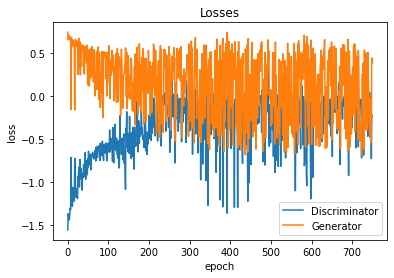

In [31]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

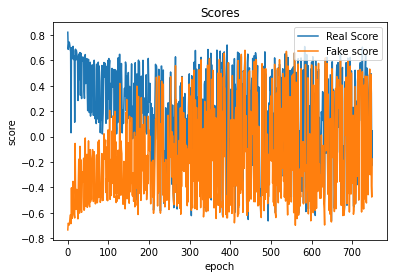

In [32]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [33]:
import glob
from PIL import Image

# filepaths
fp_in = "wgan_samples/fake_images-*.png"
fp_out = "wgan_samples/fake_image.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

In [34]:
from IPython.display import Image

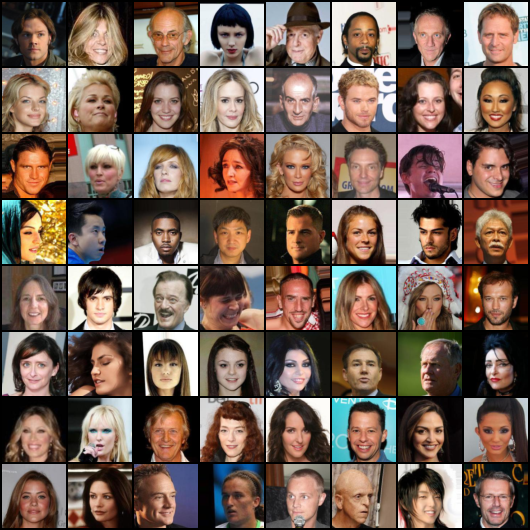

In [35]:
Image("wgan_samples/real_images.png")

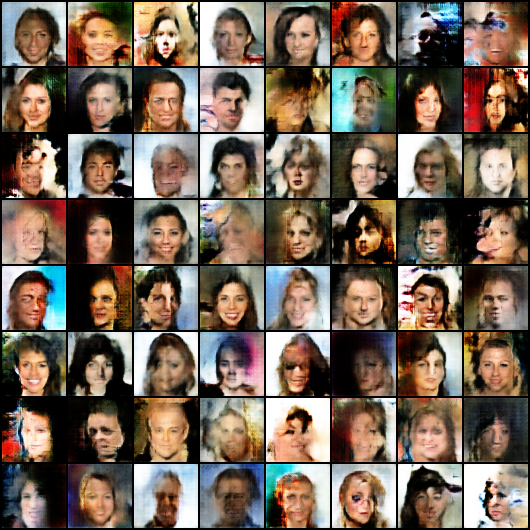

In [36]:
fake_fname = 'fake_images-{0:0=4d}.png'.format(num_epochs)
Image(os.path.join(sample_dir, fake_fname))